# Pattern Lakehouse
Sujet de stage 2023

# Snowflake account connection

In [30]:
! pip freeze > requirements/requirements.txt

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from imblearn.over_sampling import SMOTE
import opendatasets as od
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from snowflake.snowpark import version
from snowflake.snowpark.functions import udf, sproc, col
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import IntegerType, FloatType, StringType, BooleanType, Variant

print(f"Snowflake snowpark version is: {version.VERSION}")


Snowflake snowpark version is: (1, 3, 0)


In [32]:
# #!/usr/bin/env python
import snowflake.connector

# Gets the version
ctx = snowflake.connector.connect(
    user='maxellende',
    password='passwordSF22!',
    account='hovuthf-jh06936', 
    role = 'ACCOUNTADMIN',
    warehouse = 'HOL_WH',
    schema = 'PUBLIC',
    database = 'HOL_DB'

    )




# Fraud detection 

## Libraries and Data 


In [33]:
with open('creds.json') as f:
    connection_parameters = json.load(f)

In [34]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "HOL_DB"."PUBLIC"
Current Warehouse: "HOL_WH"


In [56]:
# sql = 'SELECT * from CREDIT_RECORD'
# cursor = ctx.cursor()
# cursor.execute(sql)
# df = cursor.fetch_pandas_all()


In [35]:
df = session.table('CREDIT_RECORD')

In [58]:
df.show()


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [59]:
df.describe().to_pandas()

,SUMMARY,FRAUD_BOOL,INCOME,NAME_EMAIL_SIMILARITY,PREV_ADDRESS_MONTHS_COUNT,CURRENT_ADDRESS_MONTHS_COUNT,CUSTOMER_AGE,DAYS_SINCE_REQUEST,INTENDED_BALCON_AMOUNT,ZIP_COUNT_4W,...,HOUSING_STATUS_BB,HOUSING_STATUS_BC,HOUSING_STATUS_BD,SOURCE_INTERNET,SOURCE_TELEAPP,DEVICE_OS_LINUX,DEVICE_OS_WINDOWS,DEVICE_OS_X11,DEVICE_OS_OTHER,DEVICE_OS_MACINTOSH
0,min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
2,max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,...,0.260965,0.372143,0.026161,0.992952,0.007048,0.332712,0.263506,0.007228,0.342728,0.053826
4,stddev,0.104437,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,...,0.439161,0.483377,0.159615,0.083654,0.083654,0.471185,0.440535,0.084711,0.474622,0.225675


## Scoring function

As shown above, the dataset is extremely unbalanced.
To avoid a lazy model (i.e. predict everytime "non fraud" to reach 0.98 accuracy), we have will evaluate the models using F1-score instead of accuracy. The results will be visualized through a confusion matrix

$$ F1\text{-}score = \frac{2 tp}{2tp + fp + fn}$$
where 
- tp stands for $\textit{true positive}$
- fp stands for $\textit{false positive}$
- fn stands for $\textit{false negative}$

## Pre-processing

In [60]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

**Comment**   0.7% of components are kept after PCA, we can assume that PCA is not necessary. 

## Model design

The following methods will be used : 
- Logistic regression (with Cross-validation over parameters)
- KNN (with Cross-validation over parameters)
- Classifier (gaussian)
- Tree classifier (Random Forest)

To evaluate our models, we will use as scoring function F1 for the unbalanced fraud positive dataset and 

## Model development


In [62]:
df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [63]:
# def score_classifier(X,estimator,parameters, y, scaler = StandardScaler()):

#     # search for best parameters
#     pipeline = Pipeline([('scaler', scaler), ('estimator', estimator)]) # scale training dataset and test dataset in folds independently
#     clf = GridSearchCV(pipeline, parameters, scoring ='f1', verbose =1)
#     clf.fit(X,y)

#     # evaluate best estimator
#     best_estimator = clf.best_estimator_
#     parameters = clf.best_params_
#     score = clf.best_score_
#     title = str(best_estimator)+'\n f1-score (CV): '+str(score)
#     y_pred = clf.predict(X) # same as best_estimator.predict(X)
#     cm = confusion_matrix(y, y_pred)
#     disp = ConfusionMatrixDisplay(cm)
#     disp.plot()
#     plt.title(title)
#     plt.show()
#     return(best_estimator, parameters, y_pred, score, cm)


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Text(0.5, 1.0, 'Repartition of fraud cases in the dataset \nFRAUD_BOOL    0.011029\ndtype: float64% fraud')

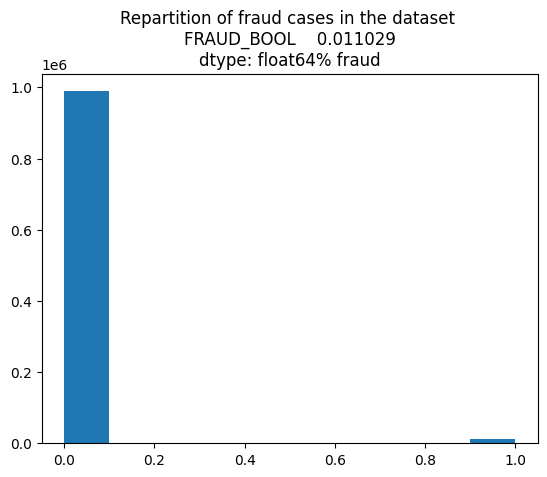

In [64]:
X = df.drop("FRAUD_BOOL").to_pandas()
y = df.select("FRAUD_BOOL").to_pandas()


class_weight = {1 : int(np.sum(y)), 0 : len(y) - int(np.sum(y))}
plt.hist(y)
plt.title(f'Repartition of fraud cases in the dataset \n{np.mean(y)}% fraud')


In [65]:
df.select(list(numeric_cols)).to_pandas()

,INCOME,NAME_EMAIL_SIMILARITY,DAYS_SINCE_REQUEST,INTENDED_BALCON_AMOUNT,VELOCITY_6H,VELOCITY_24H,VELOCITY_4W,PROPOSED_CREDIT_LIMIT,SESSION_LENGTH_IN_MINUTES
0,0.7,0.888458,0.028672,37.171430,5906.291306,5028.174670,5128.636077,500.0,6.678855
1,0.8,0.553040,0.003696,-0.620826,3309.130203,4154.590924,4869.300057,200.0,5.062323
2,0.2,0.693394,0.006649,-1.462540,15339.587256,5556.277794,4810.909455,200.0,2.565522
3,0.9,0.302103,0.022272,-1.346800,5290.478223,5982.027409,4770.146612,1500.0,6.139665
4,0.1,0.830652,0.006943,-1.052751,1872.284241,3044.960404,4872.508243,200.0,4.898575
...,...,...,...,...,...,...,...,...,...
999995,0.1,0.282273,0.021044,-0.561479,4696.438611,4206.209279,4394.491982,200.0,7.324687
999996,0.5,0.173940,0.004236,-1.541315,7887.397133,4582.476082,4102.231119,200.0,0.841650
999997,0.3,0.331326,0.028655,-1.289780,5980.446095,4967.671598,4923.622570,200.0,8.672721
999998,0.4,0.317920,0.043802,-1.025027,3535.226147,3096.932073,4308.909746,200.0,2.160107


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
numeric_cols = df.to_pandas().select_dtypes(include=['float64']).columns
X_train = pd.DataFrame(X_train, df.columns)
X_test = pd.DataFrame(X_test, df.columns)

scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.fit(X_test[numeric_cols])


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [67]:
X_train

,INCOME,NAME_EMAIL_SIMILARITY,PREV_ADDRESS_MONTHS_COUNT,CURRENT_ADDRESS_MONTHS_COUNT,CUSTOMER_AGE,DAYS_SINCE_REQUEST,INTENDED_BALCON_AMOUNT,ZIP_COUNT_4W,VELOCITY_6H,VELOCITY_24H,...,HOUSING_STATUS_BB,HOUSING_STATUS_BC,HOUSING_STATUS_BD,SOURCE_INTERNET,SOURCE_TELEAPP,DEVICE_OS_LINUX,DEVICE_OS_WINDOWS,DEVICE_OS_X11,DEVICE_OS_OTHER,DEVICE_OS_MACINTOSH
FRAUD_BOOL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INCOME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NAME_EMAIL_SIMILARITY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PREV_ADDRESS_MONTHS_COUNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CURRENT_ADDRESS_MONTHS_COUNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUSTOMER_AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAYS_SINCE_REQUEST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INTENDED_BALCON_AMOUNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP_COUNT_4W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VELOCITY_6H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:

from sklearn.decomposition import PCA
n_before = X_train.shape[1]
pca = PCA(n_components=0.90)
X_train = pca.fit_transform(X_train)
print(f"Before PCA : {n_before} components \nAfter PCA : {pca.n_components_} components, explained variance : 0.9")
print("Explained variances : ", pca.explained_variance_ratio_)


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
smote = SMOTE()
X_train = smote.fit_resample(X_train, y_train)

In [ ]:
# def score_classifier(estimator,parameters, X_train, y_train, scaler = StandardScaler()):

#     # search for best parameters
#     cv = StratifiedKFold(n_splits = 5, shuffle = True).split(X_train,y_train)
#     clf = GridSearchCV(estimator, parameters, scoring ='recall', verbose =1, cv = cv)
#     clf.fit(X_train,y_train)

#     # evaluate best estimator
#     best_estimator = clf.best_estimator_
#     parameters = clf.best_params_
#     score = clf.best_score_
#     print(f'Average score of the best estimator : {score}')
#     y_pred = clf.predict(X_test) # same as best_estimator.predict(X)
#     cm = confusion_matrix(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     disp = ConfusionMatrixDisplay(cm)
#     disp.plot()
#     title = str(estimator)+'\n f1-score on test dataset : '+str(f1)
#     plt.title(title)
#     plt.show()
#     return(best_estimator, parameters, y_pred, score, cm)


In [ ]:
def score_classifier(estimator,parameters, X_train, y_train, X_test, y_test):

    # search for best parameters
    cv = StratifiedKFold(n_splits = 5, shuffle = True).split(X_train,y_train)
    clf = GridSearchCV(estimator, parameters, scoring ='recall', verbose =1, cv = cv)
    clf.fit(X_train,y_train)

    # evaluate best estimator
    best_estimator = clf.best_estimator_
    parameters = clf.best_params_
    score = clf.best_score_
    print(f'Average score of the best estimator : {score}')
    y_pred = clf.predict(X_test) # same as best_estimator.predict(X)
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    title = str(estimator)+'\n f1-score on test dataset : '+str(f1)
    plt.title(title)
    plt.show()
    return(best_estimator, parameters, y_pred, score, cm)


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the random forest
    'max_depth': [None, 5, 10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}
estimator = RandomForestClassifier()
best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, param_grid, y)
save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

In [ ]:
df_pred = pd.DataFrame(pd.concat(X_test, y_test)).copy()
session.write_pandas(df_pred, table_name='PREDICTIONS', auto_create_table=True, overwrite=True)
df_pred = session.table('PREDICTIONS')
df_pred.show()


# To have the correct data types, we initialize the table
estimator = LogisticRegression(verbose = 1)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
score = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test,y_pred)
parameters = estimator.get_params()

df_score = pd.DataFrame(columns = ['estimator', 'parameters', 'score', 'tp', 'fp', 'fn', 'tn'])
name = str(estimator)[:-11]
row = [name, str(parameters), score, cm[0,0], cm[0,1], cm[1,0], cm[1,1]]
df_score.loc[0] = row

session.write_pandas(df_score, table_name='SCORES', auto_create_table=True, overwrite=True)
df_score = session.table('SCORES')

def uppercase_all_columns(df: snowflake.snowpark.DataFrame) -> snowflake.snowpark.DataFrame:
    return df.select([F.col(column).as_(column.upper()) for column in df.columns])
df_score = uppercase_all_columns(df_score)
df_score.write.save_as_table(table_name='SCORES', mode='overwrite')

df_score = session.table('SCORES')
df_score.show()


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished
c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\snowflake\snowpark\session.py:1383: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(


------------------------------------------------------------------------------------------------------------------------------------
|"ESTIMATOR"         |"PARAMETERS"                                        |"SCORE"             |"TP"    |"FP"    |"FN"    |"TN"    |
------------------------------------------------------------------------------------------------------------------------------------
|LogisticRegression  |{'C': 1.0, 'class_weight': None, 'dual': False,...  |0.5674273162498402  |537584  |451387  |418460  |570511  |
------------------------------------------------------------------------------------------------------------------------------------



In [ ]:
from snowflake.snowpark.functions import lit
from snowflake.snowpark import Row, Column

In [ ]:
def save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm):
    name = str(estimator)[:-11]
    session.sql("ALTER TABLE PREDICTIONS ADD COLUMN IF NOT EXISTS {} float(20)".format(name)).collect()
    df_pred = session.table('PREDICTIONS')


    row = [name, str(parameters), float(str(score)), cm[0,0], cm[0,1], cm[1,0], cm[1,1]]
    df_score =df_score.to_pandas()
    df_score.loc[len(df_score)] = row
    print(df_score)
    session.write_pandas(df_score, table_name='SCORES', auto_create_table=True, overwrite=True)
    



In [ ]:
y = y.values.ravel()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 362 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 327 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 497 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 413 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 489 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 6843 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 114.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 356 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 947 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 381 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 491 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 477 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 364 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 347 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 321 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 349 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 280 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 275 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min finished


max_iter reached after 262 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 251 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 254 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 300 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 290 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 301 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 302 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 293 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.9min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 244 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 238 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 237 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 256 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 334 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 334 seconds


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min finished


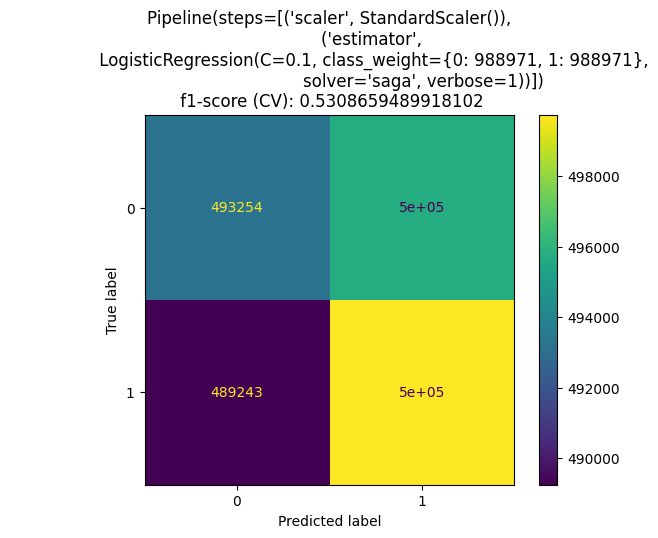

In [ ]:
estimator = LogisticRegression(verbose = 1)
parameters = {
    'estimator__penalty': ['l1', 'l2'],  # Regularization penalty: L1 or L2
    'estimator__C': [0.1, 1, 10],  # Inverse of regularization strength
    'estimator__solver': ['liblinear', 'saga']  # Solver algorithm: 'liblinear' for small datasets, 'saga' for large datasets
}
best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)
save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

In [ ]:
estimator = KNeighborsClassifier(verbose = 1)
parameters = {
    'estimator__n_neighbors': [3, 5, 7],  # Number of neighbors to consider
    'estimator__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute nearest neighbors
    'estimator__p': [1, 2]  # Parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}
best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)
save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
parameters = {
    'estimator__C': [0.1, 1, 10],  # Regularization parameter
    'estimator__kernel': ['linear', 'rbf'],  # Kernel type: linear or radial basis function (RBF)
    'estimator__gamma': ['scale', 'auto'],  # Kernel coefficient for RBF
}
estimator = svm.SVC(verbose = 1)
best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)
save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:

parameters = {
    'estimator__criterion': ['gini', 'entropy'],  # Split criterion: Gini impurity or information gain
    'estimator__max_depth': [None, 5, 10],  # Maximum depth of the tree
    'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'estimator__max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
}
estimator = DecisionTreeClassifier(verbose = 1)
best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)
save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

In [ ]:
parameters = {
    'estimator__n_estimators': [100, 200, 300],  # Number of trees in the random forest
    'estimator__max_depth': [None, 5, 10],  # Maximum depth of each tree
    'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'estimator__max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
    'estimator__bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}
estimator = RandomForestClassifier(verbose = 1)
best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)
save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from imblearn.over_sampling import SMOTE
import opendatasets as od
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from snowflake.snowpark import version
from snowflake.snowpark.functions import udf, sproc, col
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import IntegerType, FloatType, StringType, BooleanType, Variant

print(f"Snowflake snowpark version is: {version.VERSION}")

Snowflake snowpark version is: (1, 3, 0)


In [41]:
    table_name = 'CREDIT_RECORD'
    target = 'FRAUD_BOOL'
    clf = 'lr'


    # Load features
    df = session.table(table_name).to_pandas()
    print(df.head(), flush=True)
    X = df.drop(target, axis = 1)
    y = df[target]

    # Split dataset into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = 42)
    X_train, y_train = SMOTE().fit_resample(X_train,y_train)

    # Preprocess numeric columns
    numeric_features = df.select_dtypes(include=['float64']).columns
    numeric_transformer = Pipeline(steps=[('poly',PolynomialFeatures(degree = 2)),('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

    
    def score_classifier(estimator,param_grid, X_train, y_train, X_test, y_test):

        pipeline = Pipeline(steps=[('preprocessor', preprocessor),('pca', PCA(n_components = 0.9)),('estimator', estimator)])

        # search for best parameters
        cv = StratifiedKFold(n_splits = 5, shuffle = True).split(X_train,y_train)
        clf = GridSearchCV(pipeline, param_grid, scoring ='recall', verbose =1, cv = cv)
        clf.fit(X_train,y_train)

        # evaluate best estimator
        best_estimator = clf.best_estimator_
        parameters = clf.best_params_
        train_score = clf.best_score_
        print(f'Average score of the best estimator (training dataset) : {train_score}')
        y_pred = clf.predict(X_test) # same as best_estimator.predict(X)
        cm = confusion_matrix(y_test, y_pred)
        test_score = recall_score(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        title = str(estimator)+'\n Recall score on test dataset : '+str(test_score)
        plt.title(title)
        plt.show()
        return(best_estimator, parameters, y_pred, train_score, test_score, cm)

    # Create pipeline and train
    if clf == 'lr' : 

        estimator = LogisticRegression()
        param_grid = {
                'estimator__penalty': ['l1', 'l2'],  # Regularization penalty: L1 or L2
                'estimator__C': [0.1, 1, 10],  # Inverse of regularization strength
                'estimator__solver': ['liblinear', 'saga']  # Solver algorithm: 'liblinear' for small datasets, 'saga' for large datasets
        }   
        best_estimator, parameters, y_pred, train_score, test_score, cm = score_classifier(estimator,param_grid, X_train, y_train, X_test, y_test)   
    
    if clf == 'svm' : 
        parameters = {
            'estimator__C': [0.1, 1, 10],  # Regularization parameter
            'estimator__kernel': ['linear', 'rbf'],  # Kernel type: linear or radial basis function (RBF)
            'estimator__gamma': ['scale', 'auto'],  # Kernel coefficient for RBF
        }
        estimator = svm.SVC()
        best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)


    if clf == 'dt' : 
        parameters = {
            'estimator__criterion': ['gini', 'entropy'],  # Split criterion: Gini impurity or information gain
            'estimator__max_depth': [5, 10],  # Maximum depth of the tree
            'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
            'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
            'estimator__max_features': [0.99, 'sqrt'],  # Number of features to consider when looking for the best split
        }
        estimator = DecisionTreeClassifier(verbose = 1)
        best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)

    
    if clf == 'rf' : 
        parameters = {
        'estimator__n_estimators': [10, 100],  # Number of trees in the random forest
        'estimator__max_depth': [5, 10],  # Maximum depth of each tree
        'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        'estimator__max_features': [0.99, 'sqrt'],  # Number of features to consider when looking for the best split
        'estimator__bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
        }
        estimator = RandomForestClassifier(verbose = 1)
        best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)


    if clf == 'lgb' : 
        estimator = lgb.LGBMClassifier()
        param_grid = {
            'estimator__boosting_type': ['gbdt', 'dart'],  # Boosting type: Gradient Boosting Decision Tree (gbdt) or Dart
            'estimator__num_leaves': [31, 63, 127],  # Maximum number of leaves in one tree
            'estimator__learning_rate': [1.0, 0.1, 0.01],  # Learning rate
            'estimator__subsample': [0.8, 1.0],  # Subsample ratio of the training instances
            'estimator__colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree
            'estimator__reg_alpha': [0.0, 0.1, 0.5],  # L1 regularization term
            'estimator__reg_lambda': [0.0, 0.1, 0.5]  # L2 regularization term
        }

        best_estimator, parameters, y_pred, score, cm = score_classifier(estimator,param_grid, X_train, y_train, X_test, y_test)


    # # Upload trained model to a stage
    # model_file = os.path.join('/tmp', str(estimator)+'.joblib')
    # dump(best_estimator, model_file)
    # session.file.put(model_file, "@ml_models",overwrite=True)

    # return {"Classifier tested" : str(estimator), "Recall score on Train": train_score,"R2 score on Test": test_score}


   FRAUD_BOOL  INCOME  NAME_EMAIL_SIMILARITY  PREV_ADDRESS_MONTHS_COUNT  \
0           0     0.7               0.888458                         -1   
1           0     0.8               0.553040                         -1   
2           0     0.2               0.693394                         30   
3           0     0.9               0.302103                        113   
4           0     0.1               0.830652                         -1   

   CURRENT_ADDRESS_MONTHS_COUNT  CUSTOMER_AGE  DAYS_SINCE_REQUEST  \
0                            81            30            0.028672   
1                           109            40            0.003696   
2                            69            20            0.006649   
3                             5            50            0.022272   
4                           241            50            0.006943   

   INTENDED_BALCON_AMOUNT  ZIP_COUNT_4W   VELOCITY_6H  ...  HOUSING_STATUS_BA  \
0               37.171430          1279   5906.291306

NameError: name 'recall_score' is not defined

In [ ]:

# estimator = LogisticRegression()
# parameters = {
#     'estimator__penalty': ['l1', 'l2'],  # Regularization penalty: L1 or L2
#     'estimator__C': [0.1, 1, 10],  # Inverse of regularization strength
#     'estimator__solver': ['liblinear', 'saga']  # Solver algorithm: 'liblinear' for small datasets, 'saga' for large datasets
# }
# best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)
# save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

In [ ]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
import numpy as np

In [ ]:
import opendatasets as od
import pandas as pd

In [ ]:
import time
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline


In [ ]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import udf, sproc, col
from snowflake.snowpark.types import IntegerType, FloatType, StringType, BooleanType, Variant
from snowflake.snowpark import functions as fn

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

from snowflake.snowpark import version
print(f"Snowflake snowpark version is : {version.VERSION}")

Snowflake snowpark version is : (1, 3, 0)
